In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# adfuller test
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)  # p<0.05, Stationary

In [3]:
ten_stocks_close = pd.read_csv('close_df.csv')

In [4]:
pool = ["600094.XSHG",    
        "600160.XSHG", 
        "600008.XSHG",
        "600903.XSHG",
        "000959.XSHE",
        "600970.XSHG",
        "002302.XSHE",
        "600823.XSHG",
        "002503.XSHE",
        "600664.XSHG"]

In [5]:
close_price = ten_stocks_close['600903.XSHG'].dropna()

## Ljung Box Test on close price

In [6]:
import statsmodels.api as sm
sm.stats.acorr_ljungbox(close_price, lags=[12], return_df=True) # The p-value closes to 0. Has dependency

,lb_stat,lb_pvalue
12,6613.579243,0.0


## Stationarity on close price first

In [7]:
test_stationarity(close_price) # p-value is smaller than 0.05

Results of Dickey-Fuller Test:
Test Statistic                  -3.094595
p-value                          0.026956
#Lags Used                      11.000000
Number of Observations Used    721.000000
Critical Value (1%)             -3.439452
Critical Value (5%)             -2.865557
Critical Value (10%)            -2.568909
dtype: float64


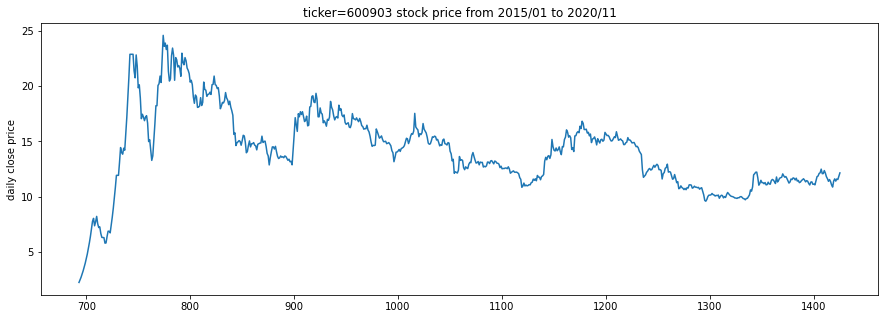

In [8]:
# visualize daily close data, lable y = column 1, ticker = 600094
close_price.plot(figsize=(15,5))
plt.ylabel('daily close price')
plt.title('ticker=600903 stock price from 2015/01 to 2020/11')
plt.show()

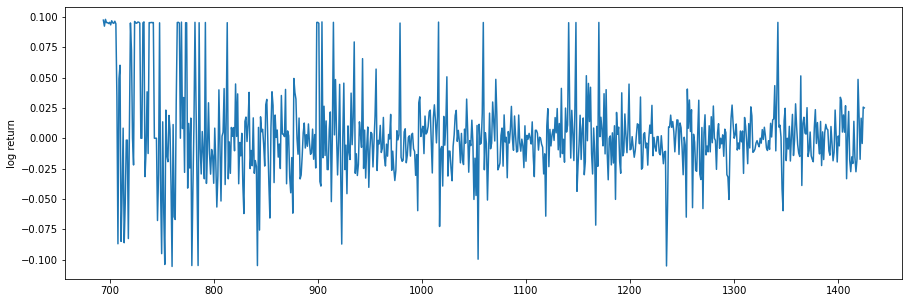

In [9]:
log_rtn = np.log(close_price).diff(1).dropna()
log_rtn.plot(figsize=(15,5))
plt.ylabel('log return')
plt.show()

## Test stationarity

In [10]:
test_stationarity(log_rtn) #p-value is small, it's stationary

Results of Dickey-Fuller Test:
Test Statistic                -9.858374e+00
p-value                        4.298411e-17
#Lags Used                     4.000000e+00
Number of Observations Used    7.270000e+02
Critical Value (1%)           -3.439377e+00
Critical Value (5%)           -2.865524e+00
Critical Value (10%)          -2.568891e+00
dtype: float64


## ACF & PACF

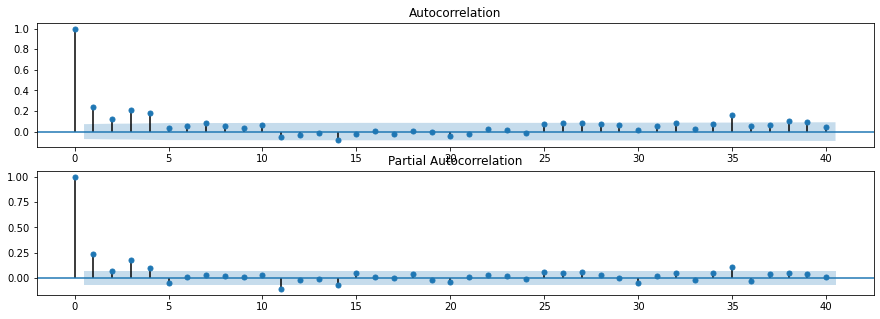

In [11]:
# acf & pacf for log return
import statsmodels.api as sm
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(log_rtn, lags=40, ax=ax1) 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(log_rtn, lags=40, ax=ax2)

## Distribution of log return

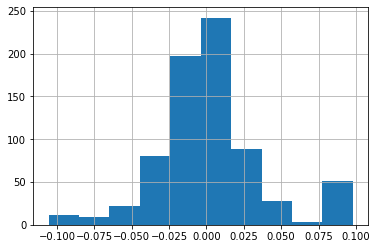

In [12]:
log_rtn.hist()
plt.show()

## Fit ARMA Model

In [13]:
import pandas as pd
import itertools
import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.arima_model import ARIMA

p = range(5)
q = range(5)

combinations = list(itertools.product(p, q))
combinations = combinations[1:] # Drop (0,0)
def train_ARMA(param):
    try:
        p = param[0]
        q = param[1]
        model = ARIMA(log_rtn, order=(p,0,q))

        model_fit = model.fit(disp=0)

        ljung_p = sm.stats.acorr_ljungbox(model_fit.resid, lags=[12-p-q], return_df=True).values[0][1]
        aic = model_fit.aic
        return {'p': p, 'q': q, 'ljung_p': ljung_p, 'aic': aic}
    except:
        print(param)

results = pd.DataFrame(columns=['p', 'q', 'ljung_p', 'aic'])
for pq in combinations:
    results = results.append(train_ARMA(pq), ignore_index=True) 

results[results['ljung_p']>=0.05].sort_values(by=['aic'])

(1, 2)
(1, 3)
(1, 4)
(2, 3)
(4, 4)


,p,q,ljung_p,aic
13,3.0,3.0,0.191219,-2874.094110
15,4.0,0.0,0.836471,-2871.246001
16,4.0,1.0,0.982346,-2870.725925
17,4.0,2.0,0.998256,-2868.936636
3,0.0,4.0,0.792519,-2868.720316
11,3.0,1.0,0.532331,-2868.358622
12,3.0,2.0,0.862665,-2867.990574
10,3.0,0.0,0.230225,-2864.747926


## GARCH

In [14]:
mean = log_rtn.mean() # The mean closes to 0

### Check if volatility time dependency

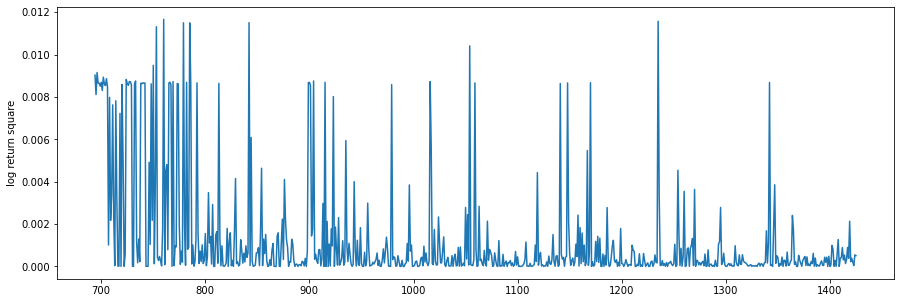

In [15]:
#log return square 
log_rtn_square = np.square(log_rtn - mean)
log_rtn_square.plot(figsize=(15,5))
plt.ylabel('log return square')
plt.show()

In [16]:
import statsmodels.api as sm

p_2 = sm.stats.acorr_ljungbox(log_rtn_square, lags=[40], return_df=True)['lb_pvalue'].values[0] # log return square is white noise if p < 0.05

print(f"P-value for squared log return: {p_2}")
if (p_2<0.05):
    print("Conclusion: Has ARCH's property in log rtn")
else:
    print("Conclusion: No ARCH's property in log rtn")

P-value for squared log return: 0.0
Conclusion: Has ARCH's property in log rtn


In [17]:
from arch.univariate import arch_model
import itertools
import warnings
warnings.filterwarnings("ignore")

p = range(1,4)
q = range(1,4)

combinations = list(itertools.product(p, q))

def train_GARCH(param):
    p = param[0]
    q = param[1]
    model = arch_model(log_rtn, mean='constant', p=p, q=q)
    
    res = model.fit(update_freq=0)
    
    ljung_p = sm.stats.acorr_ljungbox(res.std_resid, lags=[12], return_df=True).values[0][1]
    aic = res.aic
    
    return {'p':p, 'q': q, 'alpha': res.params['alpha[1]'], 'beta': res.params['beta[1]'], 'ljung_p': ljung_p, 'aic': aic}

results = pd.DataFrame(columns=['p', 'q', 'alpha', 'beta', 'ljung_p', 'aic'])
for pq in combinations:
    results = results.append(train_GARCH(pq), ignore_index=True) 

results[results['ljung_p']>=0.05].sort_values(by=['aic']) # No GARCH models are satisfactory

Optimization terminated successfully    (Exit mode 0)
            Current function value: -1521.0061868201235
            Iterations: 25
            Function evaluations: 187
            Gradient evaluations: 22
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1521.2429060609743
            Iterations: 12
            Function evaluations: 119
            Gradient evaluations: 10
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1519.5955336517873
            Iterations: 8
            Function evaluations: 48
            Gradient evaluations: 4
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1521.006132981632
            Iterations: 19
            Function evaluations: 151
            Gradient evaluations: 18
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1525.8197299961282
            Iterations: 25
            Functio

,p,q,alpha,beta,ljung_p,aic


## EGARCH

In [18]:
from arch.univariate import arch_model
import itertools
import warnings
warnings.filterwarnings("ignore")

p = range(1,4)
q = range(1,4)

combinations = list(itertools.product(p, q))

def train_EGARCH(param):
    p = param[0]
    q = param[1]
    model = arch_model(log_rtn, vol='EGARCH', mean='constant', p=p, q=q, dist='t')
    
    res = model.fit(update_freq=0)
    
    ljung_p = sm.stats.acorr_ljungbox(res.std_resid, lags=[12], return_df=True).values[0][1]
    aic = res.aic
    return {'p':p, 'q': q, 'params': res.params, 'ljung_p': ljung_p, 'aic': aic}

results = pd.DataFrame(columns=['p', 'q', 'params', 'ljung_p', 'aic'])

for pq in combinations:
    try:
        results = results.append(train_EGARCH(pq), ignore_index=True)
    except:
        continue

results[results['ljung_p']>=0.05].sort_values(by=['aic'])

Optimization terminated successfully    (Exit mode 0)
            Current function value: -1567.6028858638347
            Iterations: 85
            Function evaluations: 629
            Gradient evaluations: 83
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 5558.249116202607
            Iterations: 26
            Function evaluations: 237
            Gradient evaluations: 25
Optimization terminated successfully    (Exit mode 0)
            Current function value: 41397.705613848026
            Iterations: 25
            Function evaluations: 247
            Gradient evaluations: 22


C:\Users\oscarko\AppData\Local\Continuum\anaconda3\lib\site-packages\arch\univariate\base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1542.6541516558873
            Iterations: 80
            Function evaluations: 692
            Gradient evaluations: 76
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1571.2423434369953
            Iterations: 56
            Function evaluations: 512
            Gradient evaluations: 56
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1570.0300257933918
            Iterations: 81
            Function evaluations: 790
            Gradient evaluations: 81
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1563.2652554153005
            Iterations: 93
            Function evaluations: 959
            Gradient evaluations: 89
Optimization terminated successfully    (Exit mode 0)
            Current function value: 58730.15166956919
            Iterations: 14
            Funct

,p,q,params,ljung_p,aic
4,2,2,mu -0.001388 omega -0.045099 alph...,0.051509,-3128.484687
0,1,1,mu -0.001316 omega -0.037475 alph...,0.054002,-3125.205772
5,2,3,mu -0.001200 omega -0.070573 alph...,0.097698,-3124.060052
6,3,2,mu -0.000771 omega -0.105050 alph...,0.085328,-3110.530511
3,2,1,mu -0.000323 omega -0.032594 al...,0.101186,-3073.308303
2,1,3,mu -4.031491e+08 omega -1.587705e...,1.000000,82809.411228
